In [ ]:
import keras
keras.__version__

'2.12.0'

# Nadmierne dopasowanie i zbyt słabe dopasowanie

We wszystkich trzech zaprezentowanych wcześniej przykładach — przewidywaniu oceny filmu, klasyfikacji tematycznej i regresji ceny mieszkań — wydajność modelu podczas przetwarzania odłożonego na bok walidacyjnego zbioru danych zawsze po kilku epokach osiągała wartość szczytową, a następnie ulegała degradacji — modele zaczynały ulegać nadmiernemu dopasowaniu do danych treningowych. Do nadmiernego dopasowania może dojść podczas pracy nad dowolnym problemem uczenia maszynowego. Pracując z algorytmami uczenia maszynowego, musimy wiedzieć, jak radzić sobie z tym problemem.

Podstawowym problemem uczenia maszynowego jest kompromis między optymalizacją a uogólnianiem. Optymalizacja jest procesem dostrajania modelu w celu uzyskania najlepszej możliwej wydajności na danych treningowych (jest to proces uczenia, od którego wzięła się nazwa uczenie maszynowe), a uogólnianie odwołuje się do tego, jak dobrze wytrenowany model sprawdza się podczas przetwarzania danych, których nigdy nie widział. Oczywiście chcemy uzyskać jak najlepszą zdolność modelu do uogólniania, ale nie mamy na to wpływu w sposób bezpośredni, ponieważ model możemy modyfikować tylko na danych treningowych.

Na początku trenowania optymalizacja i uogólnianie są ze sobą skorelowane — im mniejsza strata na danych treningowych, tym mniejsza strata na danych testowych. Gdy taka sytuacja ma miejsce, mamy do czynienia ze zbyt słabym dopasowaniem — model może zostać lepiej dopasowany, ponieważ sieć nie dokonała jeszcze modelowania wszystkich wzorców znajdujących się w danych treningowych, ale po pewnej liczbie iteracji algorytmu przetwarzającego dane treningowe uogólnianie przestaje ulegać poprawie, a metryka walidacji przyjmuje wartość stałą lub pogarsza się — wówczas model zaczyna dopasowywać się nadmiernie, a więc zaczyna uczyć się wzorców, które są specyficzne dla danych treningowych i wprowadzają w błąd lub są nieprzydatne podczas przetwarzania nowych danych.

Aby zapobiec uczeniu się przez model błędnych lub zbędnych wzorców treningowego zbioru danych, najlepiej jest zebrać więcej danych treningowych. To dość oczywiste, że model trenowany na większej liczbie obserwacji będzie zdolny do lepszego uogólniania. Jeśli takie rozwiązanie nie jest możliwe, możemy modulować ilość informacji, które model może przechowywać, lub dodać ograniczenia co do możliwości przechowywania informacji przez model. Jeżeli sieć może zapamiętać tylko niewielką liczbę wzorców, to proces optymalizacji wymusi skupienie się na najważniejszych wzorcach, które najprawdopodobniej lepiej sprawdzą się przy uogólnianiu.

Proces walki z nadmiernym dopasowaniem określamy mianem regularyzacji. Chciałbym opisać najpopularniejsze techniki regularyzacji i zastosować je w praktyce w celu poprawy działania modelu klasyfikacji filmów opisanego w podrozdziale 3.4.


Uwaga: W charakterze zbioru walidacyjnego będziemy krozystać ze zbioru testowego IMDB. W tym przypadku nie jest to żadnym problemem.

Przygotujmy dane do analizy korzystając z kodu przedstawionego w sekcji 3.5.:

In [ ]:
from keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [ ]:
train_data.shape

(25000,)

In [ ]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [ ]:
train_labels

array([1, 0, 0, ..., 0, 1, 0])

In [ ]:
def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Zbiór treningowy w postaci wektora.
x_train = vectorize_sequences(train_data)
# Zbiór testowy w postaci wektora.
x_test = vectorize_sequences(test_data)
# Etykiety w postaci wektorów.
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [ ]:
x_train.shape

(25000, 10000)

In [ ]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [ ]:
y_train[0]

1.0

# Zmniejszanie nadmiernego dopasowania

## Redukcja rozmiaru sieci


Najprostszym sposobem zapobiegania powstawaniu nadmiernego dopasowania jest zmniejszenie rozmiaru modelu: zmniejszenie liczby uczonych parametrów, na którą wpływa liczba warstw i liczba jednostek je tworzących. W uczeniu głębokim uczone parametry modelu często określa się mianem pojemności modelu. Model dysponujący większą liczbą parametrów charakteryzuje się większą pojemnością pamięci, a więc może łatwiej uczyć się doskonałego mapowania danych przypominającego swym działaniem słownik. Mapowanie takie nie ma żadnej zdolności uogólniania. Przykładowy model z 500 000 parametrów binarnych mógłby z łatwością nauczyć się klasy każdej cyfry wchodzącej w skład treningowego zbioru danych MNIST: każda z 50 000 cyfr mogłaby zostać opisana przy użyciu zaledwie 10 parametrów binarnych, ale taki model byłby zupełnie nieprzydatny podczas klasyfikacji nowych próbek. Musisz pamiętać o tym, że modele uczenia głębokiego mają tendencję do dopasowywania się do danych treningowych, ale Twoim celem jest osiągnięcie modelu zdolnego do jak najlepszych uogólnień, a nie modelu maksymalnie dopasowanego do danych treningowych.

Jeżeli sieć dysponuje zbyt małą zdolnością zapamiętywania, to nie będzie w stanie tak łatwo nauczyć się bezpośredniego mapowania, a więc w celu minimalizacji strat będzie musiała uczyć się skompresowanych reprezentacji, co pozwoli modelowi nabyć umiejętności przewidywania, a o to nam właśnie chodzi. Jednocześnie należy pamiętać o tym, że modele powinny mieć na tyle dużo parametrów, aby nie ulec zbyt słabemu dopasowaniu — model nie powinien cierpieć z powodu braku możliwości zapamiętywania kolejnych cech. Trzeba znaleźć kompromis między zbyt dużą pojemnością a zbyt małą pojemnością.

Niestety nie ma żadnego magicznego wzoru umożliwiającego określenie właściwej liczby warstw i odpowiednich rozmiarów poszczególnych warstw. W celu znalezienia modelu optymalnego z punktu widzenia analizowanych danych należy sprawdzić działanie zestawu różnych architektur (oczywiście trzeba to robić na zbiorze walidacyjnym, a nie testowym). Szukanie odpowiedniego modelu należy zacząć od niewielkiej liczby warstw i parametrów, a następnie zwiększać rozmiary istniejących warstw i stopniowo dodawać nowe, obserwując spadek wartości straty określanej w procesie walidacji.

Spróbujmy zastosować to rozwiązanie w kontekście sieci klasyfikującej recenzje filmów. Oto kod oryginalnej sieci:


In [ ]:
from keras import models
from keras import layers

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

Spróbujmy zastąpić ten model prostszą siecią neuronową:

In [ ]:
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])


Oto porównanie straty walidacji oryginalnej sieci i mniejszej sieci. Kropkami oznaczono wartości straty walidacji mniejszej sieci, a krzyżykami oznaczono wartości straty oryginalnej sieci (przypominam, że mniejsza wartość straty walidacji świadczy o tym, że model jest lepszy).

In [ ]:
original_hist = original_model.fit(x_train, y_train,
                                   epochs=10,
                                   batch_size=512,
                                   validation_data=(x_test, y_test))

Epoch 1/10
49/49 [==============================] - 12s 120ms/step - loss: 0.4620 - acc: 0.8104 - val_loss: 0.3426 - val_acc: 0.8777
Epoch 2/10
49/49 [==============================] - 2s 49ms/step - loss: 0.2709 - acc: 0.9052 - val_loss: 0.3125 - val_acc: 0.8732
Epoch 3/10
49/49 [==============================] - 3s 58ms/step - loss: 0.2134 - acc: 0.9250 - val_loss: 0.2804 - val_acc: 0.8881
Epoch 4/10
49/49 [==============================] - 2s 35ms/step - loss: 0.1798 - acc: 0.9365 - val_loss: 0.2871 - val_acc: 0.8862
Epoch 5/10
49/49 [==============================] - 2s 37ms/step - loss: 0.1581 - acc: 0.9434 - val_loss: 0.3347 - val_acc: 0.8691
Epoch 6/10
49/49 [==============================] - 2s 40ms/step - loss: 0.1430 - acc: 0.9500 - val_loss: 0.3366 - val_acc: 0.8741
Epoch 7/10
49/49 [==============================] - 2s 48ms/step - loss: 0.1270 - acc: 0.9567 - val_loss: 0.3322 - val_acc: 0.8752
Epoch 8/10
49/49 [==============================] - 1s 29ms/step - loss: 0.1139 -

In [ ]:
original_hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
original_hist.history['acc']

[0.8113999962806702,
 0.9048799872398376,
 0.9241200089454651,
 0.9336000084877014,
 0.9424399733543396,
 0.9509199857711792,
 0.9544399976730347,
 0.9594799876213074,
 0.9643999934196472,
 0.9683200120925903]

In [ ]:
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=10,
                                       batch_size=512,
                                       validation_data=(x_test, y_test))

Epoch 1/10
49/49 [==============================] - 5s 80ms/step - loss: 0.5994 - acc: 0.6996 - val_loss: 0.5454 - val_acc: 0.7496
Epoch 2/10
49/49 [==============================] - 1s 27ms/step - loss: 0.4955 - acc: 0.8378 - val_loss: 0.4846 - val_acc: 0.8280
Epoch 3/10
49/49 [==============================] - 1s 26ms/step - loss: 0.4352 - acc: 0.8858 - val_loss: 0.4432 - val_acc: 0.8804
Epoch 4/10
49/49 [==============================] - 1s 26ms/step - loss: 0.3891 - acc: 0.9112 - val_loss: 0.4125 - val_acc: 0.8800
Epoch 5/10
49/49 [==============================] - 1s 28ms/step - loss: 0.3494 - acc: 0.9258 - val_loss: 0.3927 - val_acc: 0.8777
Epoch 6/10
49/49 [==============================] - 1s 28ms/step - loss: 0.3143 - acc: 0.9359 - val_loss: 0.3784 - val_acc: 0.8763
Epoch 7/10
49/49 [==============================] - 1s 28ms/step - loss: 0.2820 - acc: 0.9442 - val_loss: 0.3608 - val_acc: 0.8803
Epoch 8/10
49/49 [==============================] - 2s 36ms/step - loss: 0.2525 - a

In [ ]:
epochs = range(1, 11)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

# b+ to niebieskie krzyżyki
plt.plot(epochs, original_val_loss, 'b+', label='Oryginalny model')
# bo to niebieskie kropki
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Mniejszy model')

# zbiór treningowy
plt.plot(epochs, original_hist.history['loss'], 'r+', label='Oryginalny model - treningowe')
plt.plot(epochs, smaller_model_hist.history['loss'], 'ro', label='Mniejszy model - treningowe')

plt.xlabel('Epoki')
plt.ylabel('Strata walidacji')
plt.legend()

plt.show()

NameError: ignored


Jak widać, mniejsza sieć zaczęła ulegać nadmiernemu dopasowaniu (przeuczeniu) później niż nasz początkowy model (po sześciu, a nie po czterech epokach), a dodatkowo po przekroczeniu punktu przeuczenia wydajność mniejszego modelu ulega wolniejszej degradacji.

Spróbujmy przeanalizować w tym kontekście działanie sieci o znacznie większej pojemności (przekraczającej potrzeby problemu).

In [ ]:
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
bigger_model.add(layers.Dense(512, activation='relu'))
bigger_model.add(layers.Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

In [ ]:
bigger_model_hist = bigger_model.fit(x_train, y_train,
                                     epochs=30,
                                     batch_size=512,
                                     validation_data=(x_test, y_test))

Epoch 1/30
49/49 [==============================] - 4s 73ms/step - loss: 0.0596 - acc: 0.9885 - val_loss: 0.4862 - val_acc: 0.8790
Epoch 2/30
49/49 [==============================] - 2s 32ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.6114 - val_acc: 0.8788
Epoch 3/30
49/49 [==============================] - 2s 34ms/step - loss: 0.0560 - acc: 0.9899 - val_loss: 0.4970 - val_acc: 0.8781
Epoch 4/30
49/49 [==============================] - 3s 60ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.6259 - val_acc: 0.8796
Epoch 5/30
49/49 [==============================] - 3s 52ms/step - loss: 5.6229e-04 - acc: 1.0000 - val_loss: 0.6971 - val_acc: 0.8746
Epoch 6/30
49/49 [==============================] - 2s 32ms/step - loss: 3.2463e-04 - acc: 1.0000 - val_loss: 0.7322 - val_acc: 0.8787
Epoch 7/30
49/49 [==============================] - 2s 45ms/step - loss: 2.1014e-04 - acc: 1.0000 - val_loss: 0.7606 - val_acc: 0.8787
Epoch 8/30
49/49 [==============================] - 2s 33ms/step - loss

Oto rysnek, na którym porównano wydajność zbyt dużej sieci i naszego początkowego modelu. Kropkami oznaczono stratę walidacji większej sieci, a krzyżykami oznaczono stratę walidacji początkowej wersji sieci.

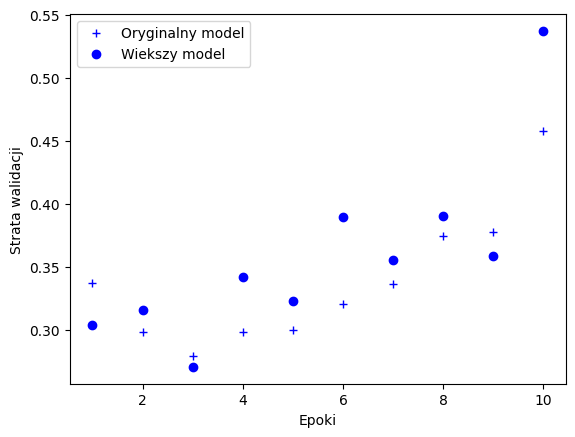

In [ ]:
import matplotlib.pyplot as plt

bigger_model_val_loss = bigger_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Oryginalny model')
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Wiekszy model')
plt.xlabel('Epoki')
plt.ylabel('Strata walidacji')
plt.legend()

plt.show()


porównano wydajność zbyt dużej sieci i naszego początkowego modelu. Kropkami oznaczono stratę walidacji większej sieci, a krzyżykami oznaczono stratę walidacji początkowej wersji sieci.

Oto rysunek, na którym porównano straty procesu trenowania dwóch sieci.


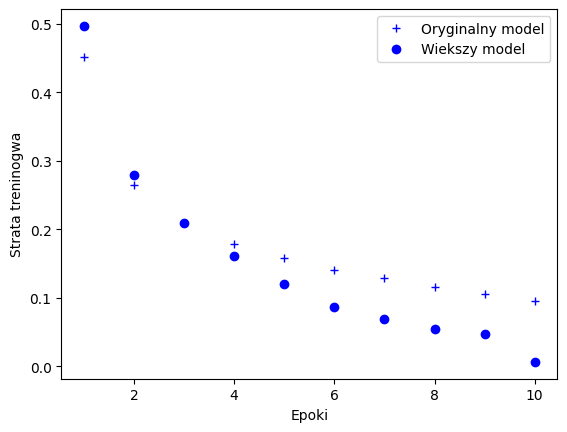

In [ ]:
original_train_loss = original_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']

plt.plot(epochs, original_train_loss, 'b+', label='Oryginalny model')
plt.plot(epochs, bigger_model_train_loss, 'bo', label='Wiekszy model')
plt.xlabel('Epoki')
plt.ylabel('Strata treninogwa')
plt.legend()

plt.show()

Widać, że większa sieć bardzo szybko uzyskuje praktycznie zerową wartość straty treningowej. Im większa jest pojemność sieci, tym szybciej modelowane są dane treningowe (uzyskiwana jest niska wartość straty treningowej), ale wzrasta wówczas podatność na nadmierne dopasowanie (powstaje duża różnica między stratą treningową a stratą walidacji).

## Dodawanie regularyzacji wag


Czy znasz zasadę brzytwy Ockhama? Według niej, jeżeli istnieją dwa wyjaśnienia jakiejś teorii, to najprawdopodobniej poprawnym wyjaśnieniem jest to, które jest prostsze — to, które czyni mniej założeń. Zasada ta sprawdza się również w kontekście modeli sieci neuronowych: jeżeli mamy dane treningowe, architekturę sieci i wiele zbiorów wartości wag (wiele modeli) opisujących dane, to prostsze modele są mniej podatne na nadmierne dopasowanie od tych, które są bardziej złożone.

Przyjmijmy, że za prostszy model uważamy model, którego rozkład wartości parametrów charakteryzuje się mniejsza entropią, lub model, który ma mniej parametrów. W związku z tym popularną techniką unikania nadmiernego dopasowania jest wymuszenie na modelu ograniczenia złożoności poprzez przyjmowanie tylko małych wartości wag, co sprawia, że rozkład wartości wag jest bardziej regularny. Zabieg ten określamy mianem regularyzacji wag. Implementuje się go poprzez dodanie do funkcji straty sieci kosztu związanego z dużymi wartościami wag. W praktyce można to zrobić na dwa sposoby:


* Regularyzacja L1 — koszt jest dodawany proporcjonalnie do bezwzględnej wartości współczynników wag (normy L1 wag).

* Regularyzacja L2 — koszt jest dodawany proporcjonalnie do kwadratu wartości współczynników wag (normy L2 wag). W kontekście sieci neuronowych regularyzacja L2 jest również określana mianem rozkładu wag. Pomimo innej nazwy jest to ten sam proces, który w matematyce określamy jako regularyzacja L2.

W pakiecie Keras regularyzację wag dodaje się poprzez przekazanie instancji regularyzatora wagi do warstw sieci za pomocą argumentu w formie słowa kluczowego. Dodajmy regularyzację L2 wag do sieci klasyfikatora recenzji filmów.

In [ ]:
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.01),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

Argument l2(0.001) oznacza, że każdy współczynnik macierzy wag warstwy doda wartość równą 0.001 * weight_coefficient_value (0,001 razy wartość współczynnika wagi) do całkowitej straty sieci. Kara ta jest dodawana tylko podczas trenowania, a więc strata sieci w czasie trenowania będzie o wiele wyższa niż w czasie testowania.

Oto wykres, na którym pokazano wpływ kary w postaci regularyzacji L2:

In [ ]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=30,
                             batch_size=512,
                             validation_data=(x_test, y_test))

Epoch 1/30
49/49 [==============================] - 7s 85ms/step - loss: 1.2374 - acc: 0.8056 - val_loss: 1.0351 - val_acc: 0.8548
Epoch 2/30
49/49 [==============================] - 1s 28ms/step - loss: 0.9433 - acc: 0.8701 - val_loss: 0.8884 - val_acc: 0.8615
Epoch 3/30
49/49 [==============================] - 1s 28ms/step - loss: 0.8140 - acc: 0.8800 - val_loss: 0.7740 - val_acc: 0.8720
Epoch 4/30
49/49 [==============================] - 1s 28ms/step - loss: 0.7167 - acc: 0.8811 - val_loss: 0.6905 - val_acc: 0.8750
Epoch 5/30
49/49 [==============================] - 2s 35ms/step - loss: 0.6412 - acc: 0.8830 - val_loss: 0.6231 - val_acc: 0.8781
Epoch 6/30
49/49 [==============================] - 1s 30ms/step - loss: 0.5821 - acc: 0.8858 - val_loss: 0.5745 - val_acc: 0.8777
Epoch 7/30
49/49 [==============================] - 1s 28ms/step - loss: 0.5367 - acc: 0.8894 - val_loss: 0.5489 - val_acc: 0.8694
Epoch 8/30
49/49 [==============================] - 1s 28ms/step - loss: 0.5063 - a

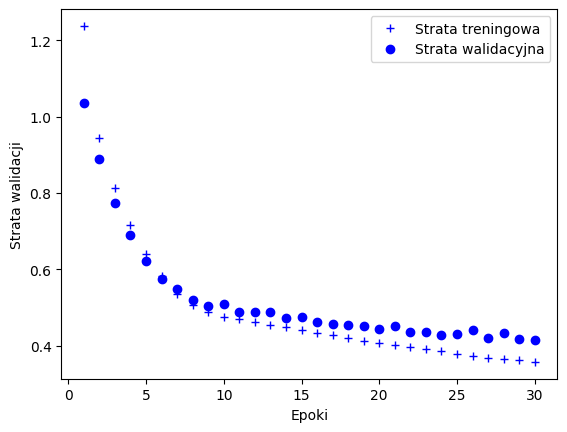

In [ ]:
import matplotlib.pyplot as plt

l2_model_val_loss = l2_model_hist.history['val_loss']
epochs=range(1,31)
plt.plot(epochs, l2_model_hist.history['loss'], 'b+', label='Strata treningowa')
plt.plot(epochs, l2_model_val_loss, 'bo', label='Strata walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Strata walidacji')
plt.legend()

plt.show()



Jak widać, model z regularyzacją L2 (kropki) stał się o wiele bardziej odporny na nadmierne dopasowanie od modelu referencyjnego (krzyżyki) pomimo tego, że oba modele charakteryzują się identyczną liczbą parametrów.

Zamiast regularyzacji L2 możesz korzystać również z innych mechanizmów regularyzacji obsługiwanych przez pakiet Keras.

In [ ]:
from keras import regularizers

# Regularyzacja L1.
regularizers.l1(0.001)

# Regularyzacja L2.
regularizers.l2(0.001)

# Jednoczesna regularyzacja L1 i L2.
regularizers.l1_l2(l1=0.001, l2=0.001)

## Porzucanie — technika dropout


Porzucanie (ang. droput) jest jedną z najbardziej skutecznych i najpopularniejszych technik regularyzacji sieci neuronowych. Opracował ją Geoff Hinton podczas współpracy ze swoimi studentami na Uniwersytecie w Toronto. Technika ta polega na losowym wybieraniu pewnej liczby cech wyjściowych warstwy podczas trenowania (wartości tych warstw są zastępowane zerami). Załóżmy, że w czasie trenowania warstwa sieci normalnie zwraca wektor [0.2, 0.5, 1.3, 0.8, 1.1]. Po przeprowadzeniu operacji porzucania w wektorze tym (w losowo wybranych miejscach) pojawią się zera i uzyska on np. formę [0, 0.5, 1.3, 0, 1.1]. Ułamek określający część wyzerowanych cech nazywamy współczynnikiem porzucania (ang. dropout rate). Zwykle parametr ten przyjmuje wartość znajdującą się w przedziale od 0,2 do 0,5. Podczas testowania żadne jednostki nie są porzucane — wartości wyjściowe warstwy sieci są skalowane o współczynnik równy współczynnikowi porzucania. Równoważy to aktywność większej liczby jednostek podczas testowania niż trenowania.

Przyjrzyjmy się macierzy Numpy zawierającej warstwę wyjściową layer_output o kształcie (rozmiar_wsadu, liczba_cech). W czasie trenowania wyzerowaliśmy losową część wartości tej macierzy:

In [ ]:
# Podczas trenowania porzucane jest 50% jednostek wyjściowych.
layer_output = np.random.randint(0, high=2)


Podczas testowania skalujemy wartości wyjściowe o współczynnik porzucania. W tym przypadku przeprowadzamy skalowanie o współczynnik 0,5 (wcześniej odrzucaliśmy połowę jednostek):

In [ ]:
# W czasie testowania:
layer_output *= 0.5


Zauważ, że proces ten można zaimplementować, wykonując obie operacje podczas trenowania i pozostawiając dane wyjściowe bez zmian w czasie testowania. Rozwiązanie takie jest często używane w praktyce (zobacz rysunek 4.8):

In [ ]:
# W czasie trenowania.
#layer_output *= np.randint(0, high=2, size=layer_output.shape)
# Zwróć wuagę na to, że w tym przypadku skalujemy raczej w górę niż w dół.
#layer_output /= 0.5


Technika ta może wydawać się dziwna i chaotyczna. Jak ma pomóc w zmniejszeniu nadmiernego dopasowania? Hinton tworząc ją, inspirował się mechanizmami zapobiegającymi nadużyciom stosowanym przez banki. Stwierdził: „Pewnego dnia, gdy poszedłem do banku, zauważyłem, że osoby w okienkach często zmieniają swoje miejsca; pracownicy banku nie potrafili powiedzieć, dlaczego to robią, ale doszedłem do wniosku, że przy takiej rotacji wyłudzenie pieniędzy z banku wymagałoby współpracy wielu pracowników; wówczas zdałem sobie sprawę, że losowe usuwanie różnych podzbiorów neuronów podczas przetwarzania każdego przykładu zapobiegnie konspiracji i zredukuje nadmierne dopasowanie”. Główną ideą tej techniki jest wprowadzenie szumu do wartości wyjściowych warstwy w celu pozbycia się nieznaczących wzorców (Hinton określił je mianem „konspiracji”) — wprowadzenie szumu zapobiega zapamiętywaniu takich wzorców przez sieć.

W pakiecie Keras technikę tę można zastosować przy użyciu warstwy Dropout, którą umieszcza się bezpośrednio za wyjściem znajdującej się wcześniej warstwy:


In [ ]:
model.add(layers.Dropout(0.5))

Dodajmy dwie warstwy Dropout do sieci IMDB i zobaczmy, czy pomogą one w zredukowaniu nadmiernego dopasowania:

In [ ]:
from keras import models
from keras import layers

dpt_model = models.Sequential()
dpt_model.add(layers.Dense(64, activation='relu',input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.3))
dpt_model.add(layers.Dense(64, activation='relu'))
dpt_model.add(layers.Dropout(0.3))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

In [ ]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=10,
                               batch_size=512,
                               validation_data=(x_test, y_test))

Epoch 1/10
49/49 [==============================] - 10s 91ms/step - loss: 0.4656 - acc: 0.7894 - val_loss: 0.3212 - val_acc: 0.8719
Epoch 2/10
49/49 [==============================] - 1s 28ms/step - loss: 0.2886 - acc: 0.8892 - val_loss: 0.2770 - val_acc: 0.8878
Epoch 3/10
49/49 [==============================] - 1s 28ms/step - loss: 0.2217 - acc: 0.9166 - val_loss: 0.2866 - val_acc: 0.8824
Epoch 4/10
49/49 [==============================] - 2s 42ms/step - loss: 0.1821 - acc: 0.9318 - val_loss: 0.2857 - val_acc: 0.8848
Epoch 5/10
49/49 [==============================] - 2s 33ms/step - loss: 0.1523 - acc: 0.9430 - val_loss: 0.2999 - val_acc: 0.8829
Epoch 6/10
49/49 [==============================] - 1s 29ms/step - loss: 0.1230 - acc: 0.9552 - val_loss: 0.3283 - val_acc: 0.8816
Epoch 7/10
49/49 [==============================] - 1s 27ms/step - loss: 0.1020 - acc: 0.9653 - val_loss: 0.3520 - val_acc: 0.8803
Epoch 8/10
49/49 [==============================] - 1s 28ms/step - loss: 0.0847 - 

Czas przedstawić wyniki na wykresie:

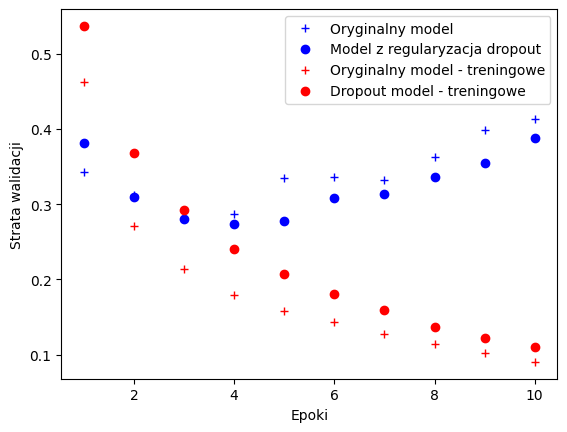

In [ ]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

import matplotlib.pyplot as plt
epochs = range(1,11)

plt.plot(epochs, original_val_loss, 'b+', label='Oryginalny model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Model z regularyzacja dropout')

# zbiór treningowy
plt.plot(epochs, original_hist.history['loss'], 'r+', label='Oryginalny model - treningowe')
plt.plot(epochs, dpt_model_hist.history['loss'], 'ro', label='Dropout model - treningowe')

plt.xlabel('Epoki')
plt.ylabel('Strata walidacji')
plt.legend()

plt.show()


Ponownie widać poprawę względem sieci referencyjnej.

Reasumując, oto najczęściej stosowane techniki mające zapobiec nadmiernemu dopasowaniu sieci neuronowych:

* Zdobycie większej ilości danych treningowych.
* Redukcja pojemności sieci.
* Dodanie regularyzacji wag.
* Dodanie mechanizmu porzucania.

# Mój model

In [ ]:
from keras import models
from keras import layers
from keras import regularizers

my_model = models.Sequential()
my_model.add(layers.Dense(32, activation='relu',input_shape=(10000,)))
my_model.add(layers.Dropout(0.3))
my_model.add(layers.Dense(16, activation='relu'))
my_model.add(layers.Dropout(0.2))
my_model.add(layers.Dense(1, activation='sigmoid'))

my_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['acc'])

my_model.summary() #podsumowanie

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                320032    
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,577
Trainable params: 320,577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
my_model_hist = my_model.fit(x_train, y_train,
                               epochs=30,
                               batch_size=512,
                               validation_data=(x_test, y_test))

Epoch 1/30
49/49 [==============================] - 7s 97ms/step - loss: 0.5117 - acc: 0.7604 - val_loss: 0.3396 - val_acc: 0.8762
Epoch 2/30
49/49 [==============================] - 2s 42ms/step - loss: 0.2945 - acc: 0.8904 - val_loss: 0.2802 - val_acc: 0.8870
Epoch 3/30
49/49 [==============================] - 1s 29ms/step - loss: 0.2205 - acc: 0.9216 - val_loss: 0.2884 - val_acc: 0.8808
Epoch 4/30
49/49 [==============================] - 1s 28ms/step - loss: 0.1726 - acc: 0.9410 - val_loss: 0.2910 - val_acc: 0.8839
Epoch 5/30
49/49 [==============================] - 1s 28ms/step - loss: 0.1406 - acc: 0.9527 - val_loss: 0.3238 - val_acc: 0.8778
Epoch 6/30
49/49 [==============================] - 2s 45ms/step - loss: 0.1112 - acc: 0.9645 - val_loss: 0.3391 - val_acc: 0.8786
Epoch 7/30
49/49 [==============================] - 2s 44ms/step - loss: 0.0908 - acc: 0.9714 - val_loss: 0.3745 - val_acc: 0.8723
Epoch 8/30
49/49 [==============================] - 1s 29ms/step - loss: 0.0714 - a